In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp 
import matplotlib.pyplot as plt
import seaborn as sns
import os, wget, shutil

# Notebook overview

## Differential Privacy and Privacy Protection
Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject carefully calibrated random noise into computations, such as LOO mean, making it mathematically difficult to isolate individual contributions. 

In this section we show how DP can be applied to data. This example revolves around anonymizing a dataset of individual heights that contains significant outliers. 

## The goal

The goal is to protect the data without compromising the privacy of any individual, especially in high risk or adversarial environments.


Down below we use usecase-2.1 individual's height.

In [2]:
os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

100% [..........................................................] 39886 / 39886
Original file downloaded.


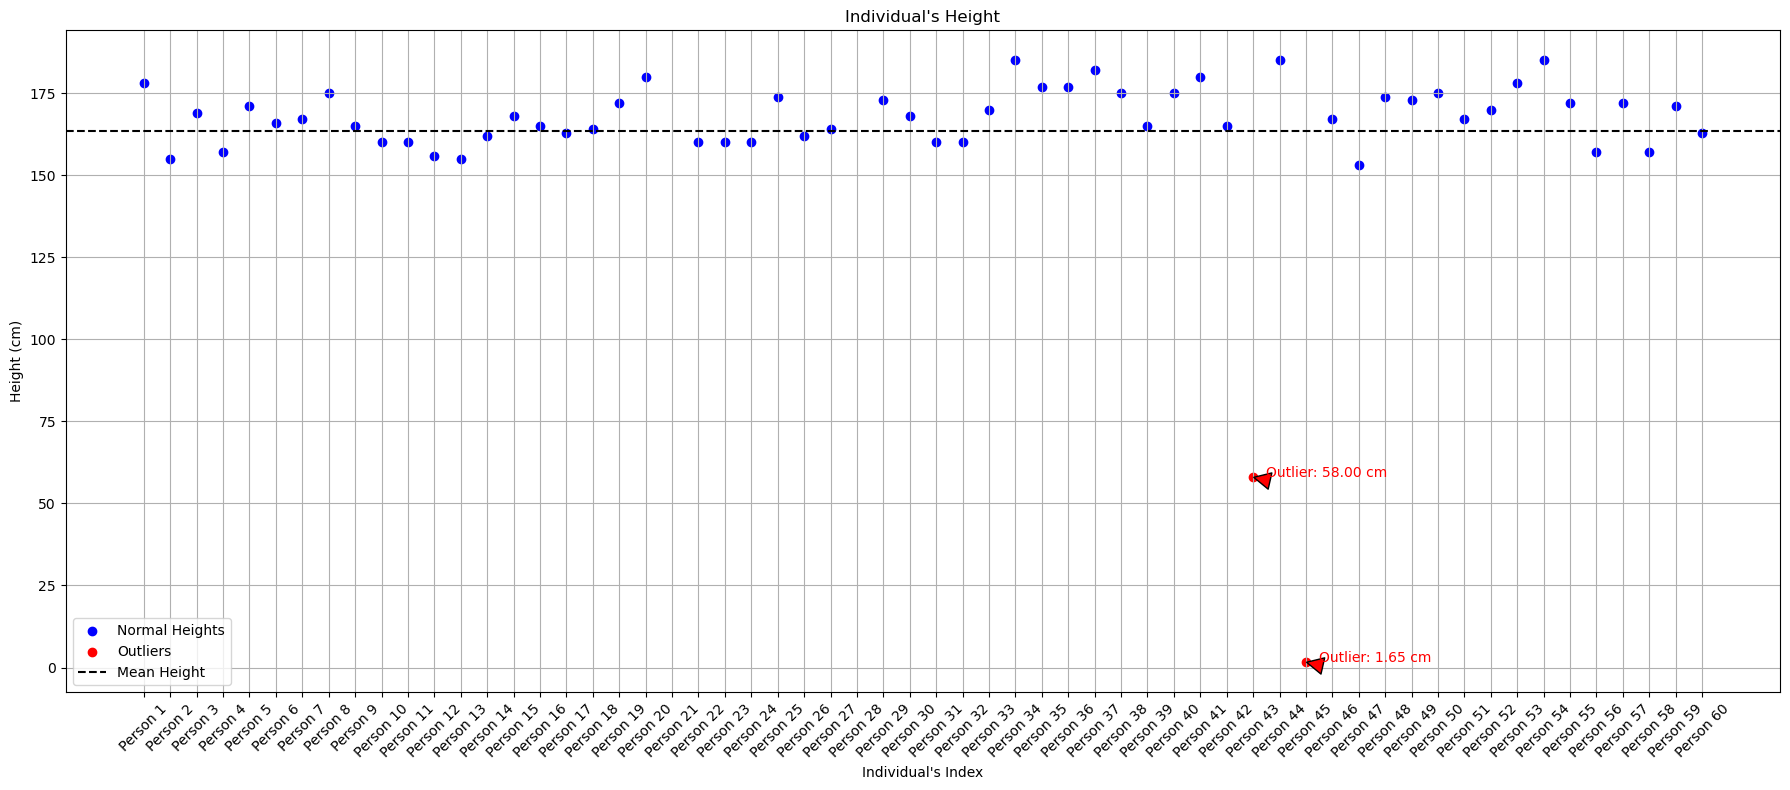

In [3]:
data = np.array(pd.read_csv("data/"+filename,delim_whitespace="\t")["Height"]).reshape(-1,1)

clean_data = data[~np.isnan(data)]
q1 = np.percentile(clean_data, 25)
q3 = np.percentile(clean_data, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
null_indices = np.where(np.isnan(data))[0]

plt.figure(figsize=(18, 8))

normal_indices = [i for i in range(len(data)) if i not in outlier_indices and i not in null_indices]
plt.scatter(normal_indices, data[normal_indices], color='blue', label='Normal Heights')
plt.scatter(outlier_indices, data[outlier_indices], color='red', label='Outliers')

for outlier_idx in outlier_indices:
    plt.annotate(f'Outlier: {data[outlier_idx][0]:.2f} cm', 
                xy=(outlier_idx, data[outlier_idx]),
                xytext=(outlier_idx+0.5, data[outlier_idx]),
                arrowprops=dict(facecolor='red', shrink=0.05),
                color='red')
"""
for null_idx in null_indices:
    plt.axvline(x=null_idx, color='red', linestyle='--', alpha=0.5, label='Null' if null_idx == null_indices[0] else "")
    
for null_idx in null_indices:
    plt.annotate('Null', 
                xy=(null_idx, np.nanmean(data)), 
                xytext=(null_idx, np.nanmean(data)*1.1),
                ha='center',
                color='red')
"""
plt.axhline(np.nanmean(data), color='black', linestyle='--', label='Mean Height')
plt.title("Individual's Height")
plt.xlabel("Individual's Index")
plt.xticks(range(len(data)), [f"Person {i + 1}" for i in range(len(data))], rotation=45)
plt.ylabel("Height (cm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Outlier

The dataset contains two clear outliers that deviate significantly from the rest. These outliers can disproportionately influence statistical summaries, making them especially privacy-sensitive.

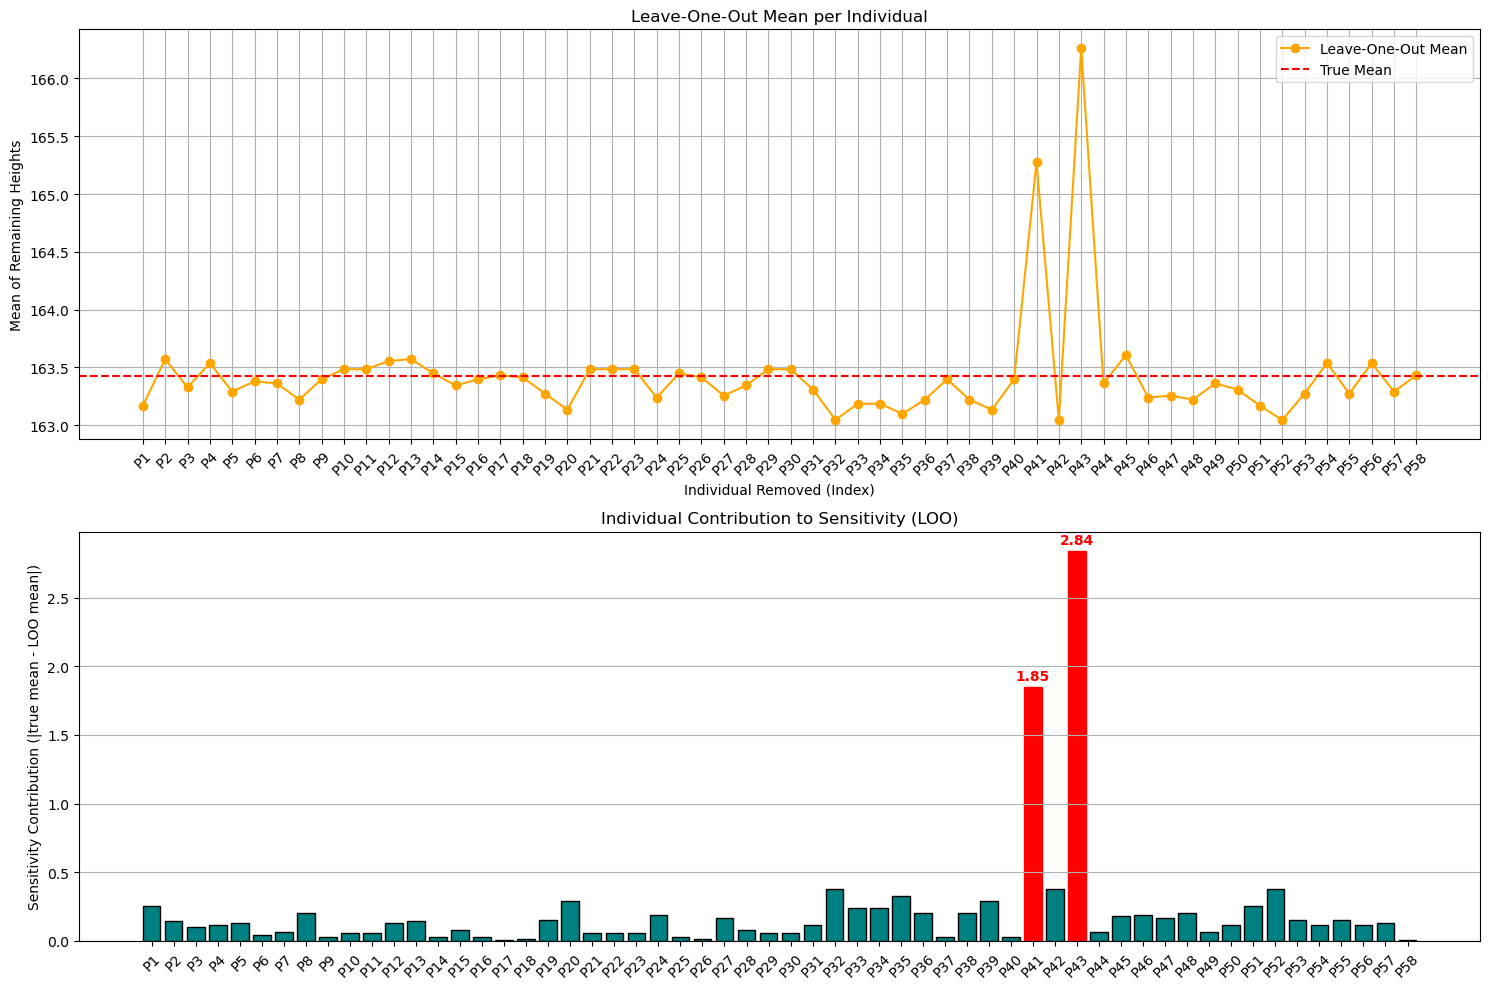

In [4]:
n = len(clean_data)
true_mean = np.mean(clean_data)
loo_means = np.array([np.mean(np.delete(clean_data, i)) for i in range(n)])

sensitivity = np.abs(true_mean - loo_means)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(range(loo_means.shape[0]), loo_means, marker='o', color='orange', label='Leave-One-Out Mean')
axes[0].axhline(true_mean, color='red', linestyle='--', label='True Mean')
axes[0].set_title("Leave-One-Out Mean per Individual")
axes[0].set_xlabel("Individual Removed (Index)")
axes[0].set_xticks(range(n))
axes[0].set_xticklabels([f"P{i + 1}" for i in range(n)], rotation=45)
axes[0].set_ylabel("Mean of Remaining Heights")
axes[0].legend()
axes[0].grid(True)

bars = axes[1].bar(range(n), sensitivity, color='teal', edgecolor='black')
axes[1].set_xticks(range(n))
axes[1].set_xticklabels([f"P{i + 1}" for i in range(n)], rotation=45)
axes[1].set_ylabel("Sensitivity Contribution (|true mean - LOO mean|)")
axes[1].set_title("Individual Contribution to Sensitivity (LOO)")
axes[1].grid(axis='y')

top_two_indices = np.argsort(sensitivity)[-2:]  
for idx in top_two_indices:
    bars[idx].set_color('red')  
    axes[1].annotate(
        f"{sensitivity[idx]:.2f}", 
        xy=(idx, sensitivity[idx]), 
        xytext=(0, 5),  
        textcoords="offset points",
        ha='center',  
        color='red',  
        weight='bold'  
    )

plt.tight_layout()
plt.show()

## Data Leakage
In the context of LOO mean estimation, we saw earlier that removing an outlier causes a large shift in the mean, revealing its strong individual impact. This high sensitivity means that an adversary could potentially detect the presence or value of an outlier by observing how the mean changes when individuals are removed. If LOO means are released without sufficient noise, outliers become vulnerable to reconstruction attacks, where their values can be inferred with high accuracy. Therefore, in differentially private analysis, identifying and mitigating the influence of such outliers is critical to ensuring privacy protection.


### DP 

If the data publisher add noise to the LOO means before releasing the result. For example, by adding Laplace noise proportional to the L1 sensitivity of the mean. The attacker cannot recover the true values exactly, because the values are altered with noise. 

We implement a DP mechanism by adding Laplace noise scaled by sensitivity, defined here as the maximum deviation between the true mean and the leave-one-out estimates.

$$
\Delta f = \max_i \left| \text{true mean} - \text{LOO mean}_i \right|
$$


Original data - average: 163.42, std: 27.03 
Reconstructed from noisy LOO - average: 166.63, std: 27.03 


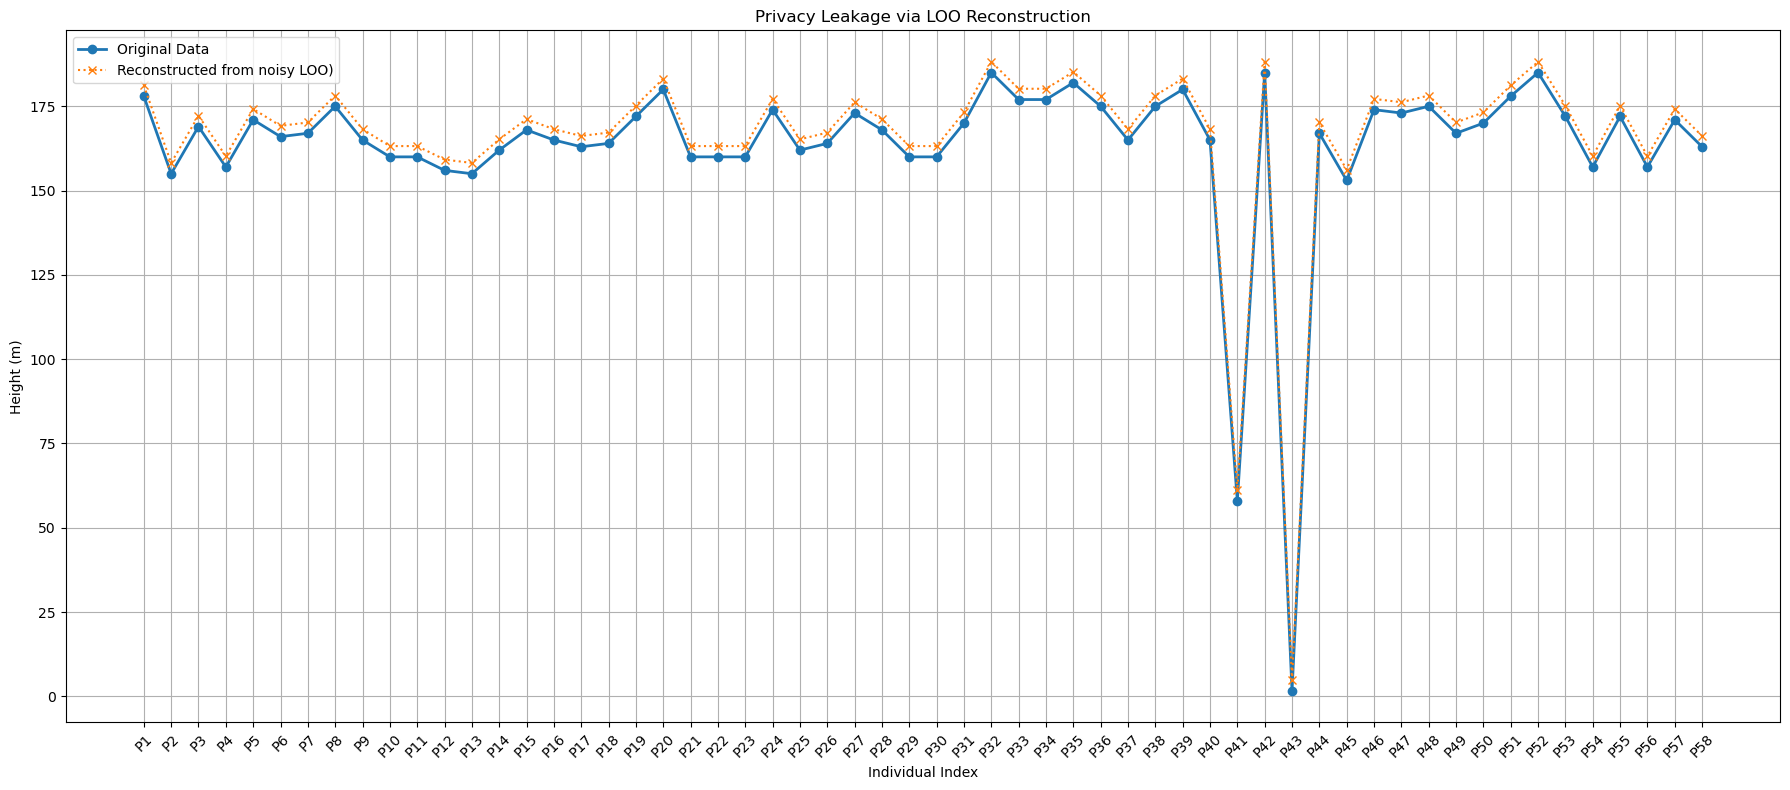

In [5]:
def dp(loo_mean):
    all_noise = np.full(loo_mean.shape[1], np.nan)

    for p_loo_mean in range(loo_mean.shape[1]):
        loo_estimate = loo_mean[:, p_loo_mean]
        loo_mean = np.mean(loo_estimate)
        loo_scale = np.std(loo_estimate)
        sensitivity = np.max(np.abs(loo_mean - loo_estimate)) 

        while True:
            noise = np.random.laplace(loc=0.0, scale=loo_scale)
            if abs(noise) >= sensitivity:
                break
            
        all_noise[p_loo_mean] = noise
    
    return all_noise


print(f"Original data - average: {np.round(clean_data.mean(), 2)}, std: {np.round(clean_data.std(), 2)} ")

noise = dp(loo_means.reshape(-1, 1))
noisy_mean = loo_means.flatten() + 1 * noise.flatten()
reconstructed_noisy = np.linalg.solve(np.ones((n, n)) - np.eye(n), (int(clean_data.shape[0]) - 1) * noisy_mean)
print(f"Reconstructed from noisy LOO - average: {np.round(reconstructed_noisy.mean(), 2)}, std: {np.round(reconstructed_noisy.std(), 2)} ")

indices = np.arange(len(clean_data))
plt.figure(figsize=(18, 8))
plt.plot(indices, clean_data, marker='o', label='Original Data', linewidth=2)
plt.plot(indices, reconstructed_noisy, marker='x', label='Reconstructed from noisy LOO)', linestyle='dotted')

plt.title("Privacy Leakage via LOO Reconstruction")
plt.xlabel("Individual Index")
plt.ylabel("Height (m)")
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## TEXT WILL BE ADDED AFTER DP CORRECTION

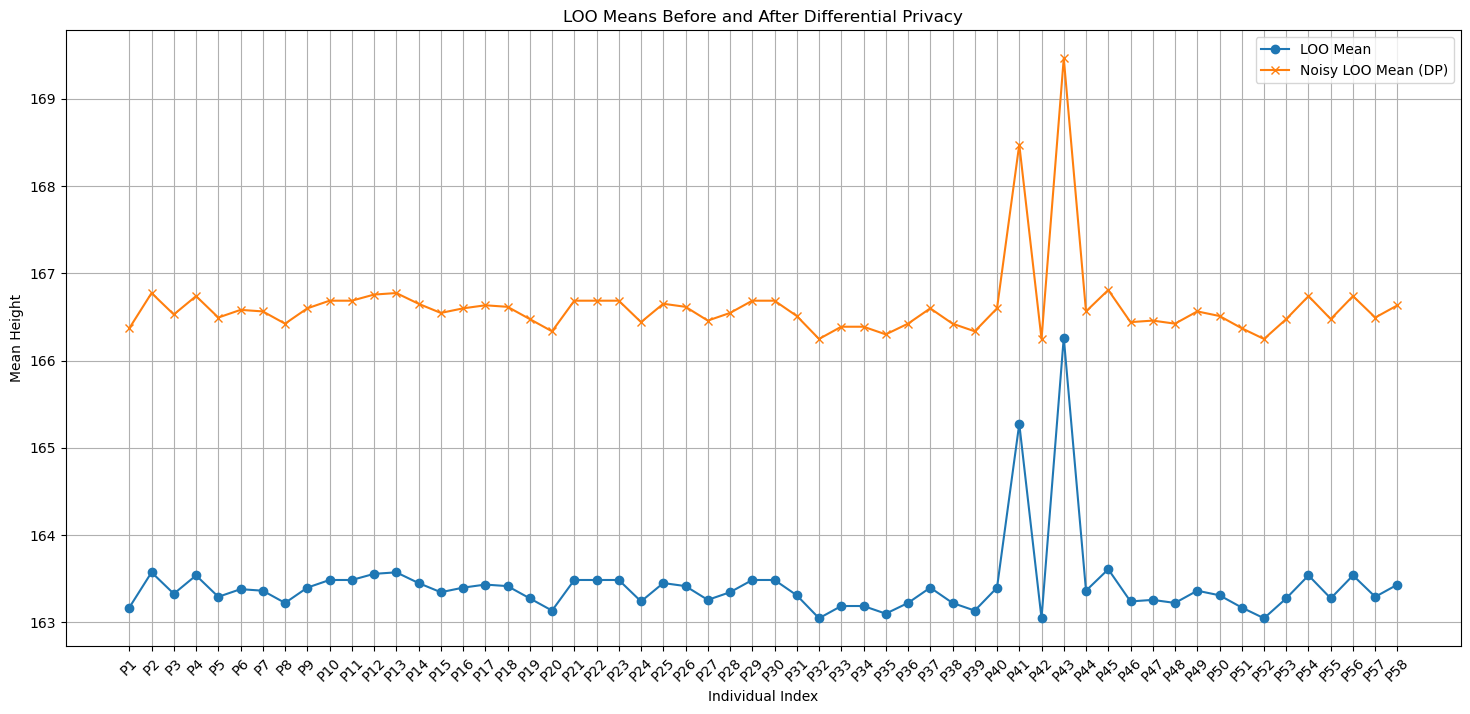

In [6]:

plt.figure(figsize=(18, 8))
plt.plot(loo_means.flatten(), label='LOO Mean', marker='o')
plt.plot(noisy_mean, label='Noisy LOO Mean (DP)', marker='x')
plt.title("LOO Means Before and After Differential Privacy")
plt.xlabel("Individual Index")
indices = np.arange(len(clean_data))
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.ylabel("Mean Height")
plt.legend()
plt.grid(True)
plt.show()


## Simulation
Here we simulate a potential privacy attack scenario where an adversary attempts to reconstruct the original individual data values from noisy LOO means.

To protect privacy, Laplace noise is added to the LOO means using the DP mechanism. However, even after adding noise, it's important to evaluate how well the attacker could still reconstruct the original values. 

The DP mechanism is randomized, each execution adds different noise. So, we run a Monte Carlo (MC) simulation 1000 times to:

- Simulate many possible outcomes of the noisy LOO release.
- Perform reconstruction attempts based on each noisy release.
- Visualize the distribution of attacker guesses for each individual’s value.

This allows us to:

- Understand the variability in the reconstructions.
- Check whether the true values are consistently hidden within a wide distribution.
- Provide empirical evidence that the data remains private on average, even if some reconstructions appear close by chance.

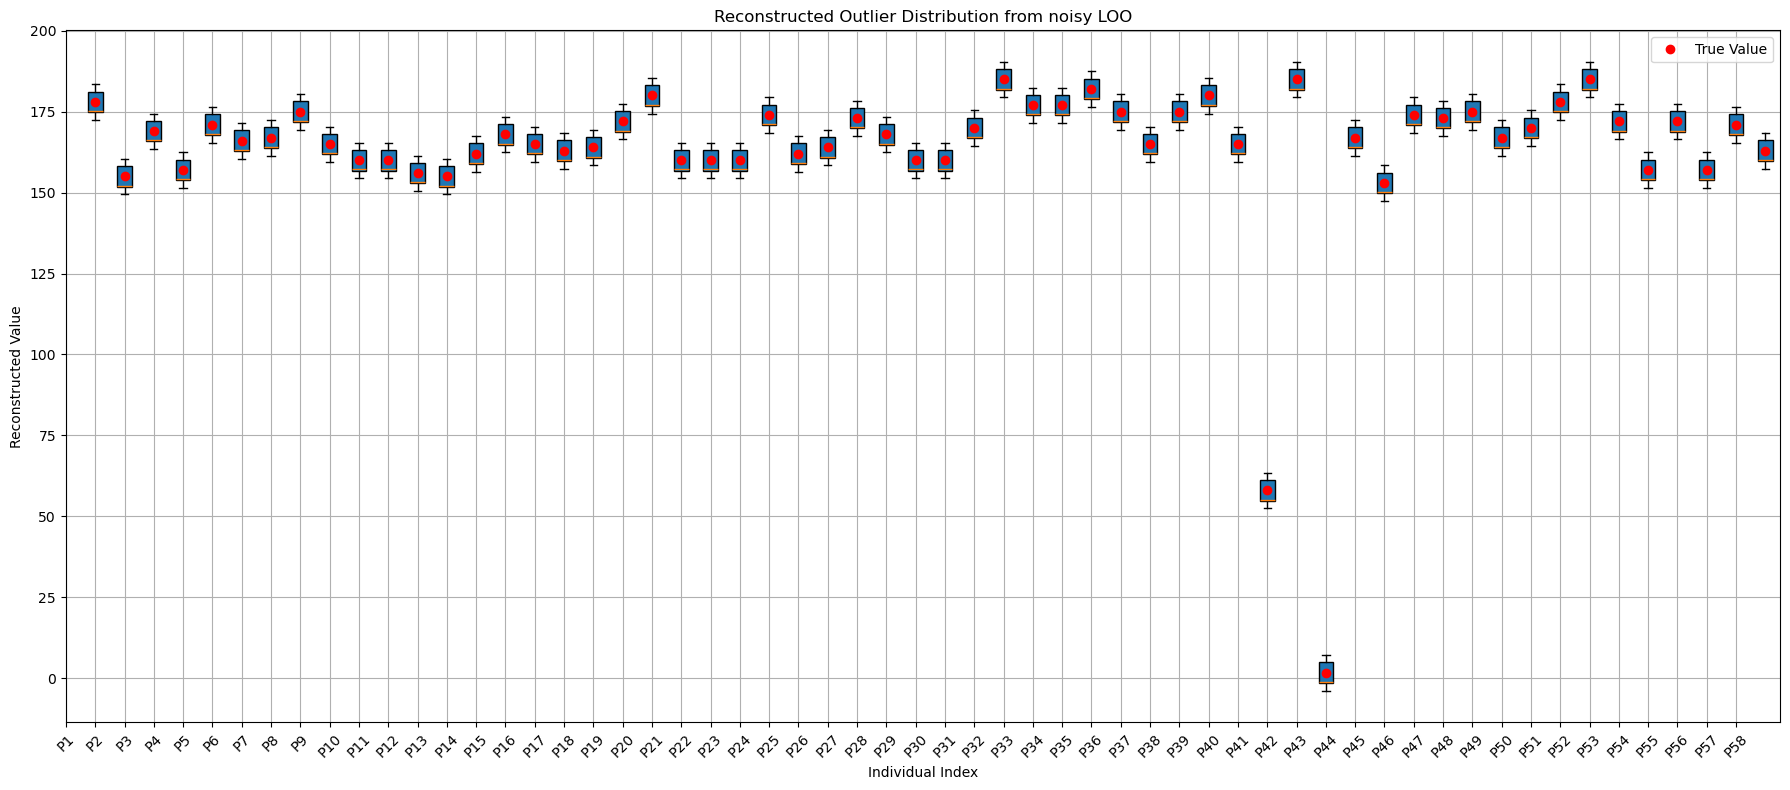

In [7]:
MC = 1000
rec = np.zeros((MC, n))  

for i in range(MC):
    noise = dp(loo_means.reshape(-1, 1))
    noisy_mean = loo_means.flatten() + 1 * noise.flatten()
    rec[i] = np.linalg.solve(np.ones((n, n)) - np.eye(n), (int(clean_data.shape[0]) - 1) * noisy_mean)

plt.figure(figsize=(18, 8))
plt.boxplot(rec, labels=[f"Person {i+1}" for i in range(n)], patch_artist=True)
plt.plot(range(1, n+1), clean_data, 'ro', label="True Value") 
plt.title("Reconstructed Outlier Distribution from noisy LOO")
plt.xlabel("Individual Index")
plt.xticks(indices, [f"P{i + 1}" for i in indices], rotation=45)
plt.ylabel("Reconstructed Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretation

## TEXT WILL BE ADDED AFTER DP CORRECTION